In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pred = pd.read_csv('/Users/dbouquin/Library/CloudStorage/OneDrive-NationalParksConservationAssociation/HelpDesk_GitLand/HD974 - West Death Rates/snowflake_ml/bequest_prediciton_alive_20241015.csv')

In [3]:
pred.columns

Index(['ROI_FAMILY_ID', 'imputer', 'y_pred', 'status'], dtype='object')

In [4]:
pred.shape

(3978, 4)

In [5]:
# Select all unique ROI_FAMILY_ID from pred
pred_ids = pred['ROI_FAMILY_ID'].unique()

In [6]:
pred_ids.shape

(1376,)

In [7]:
# Write to a csv
pred_ids_df = pd.DataFrame(pred_ids, columns=['ROI_FAMILY_ID'])
pred_ids_df.to_csv('/Users/dbouquin/Library/CloudStorage/OneDrive-NationalParksConservationAssociation/HelpDesk_GitLand/HD974 - West Death Rates/snowflake_ml/bequest_prediciton_alive_20241015_ids.csv', index=False)

In [8]:
pred_flags = pd.read_csv('predicted_bequestors_desc.csv')

In [9]:
pred_flags.shape

(828, 18)

In [10]:
pred_flags.columns

Index(['ROI FAMILY ID', 'ROI ID', 'CITY', 'STATE', 'ZIPCODE',
       'SOLICIT NO MAIL', 'NO EMAIL', 'MD GROUP', 'DEV TFP', 'MLS',
       'REG COUNCIL', 'NAT COUNCIL', 'VET COUNCIL', 'CF GROUP',
       'BOARD OR EMERITUS', 'SUPERFUND', 'SUPERFUND PLANNEDGIFT',
       'NP ROLE STAFF'],
      dtype='object')

In [11]:
# replace spaces with underscores in column names
pred_flags.columns = pred_flags.columns.str.replace(' ', '_')

In [12]:
# Select where CF_GROUP = Y
cf_group = pred_flags[pred_flags['CF_GROUP'] == 'Y']
cf_group

,ROI_FAMILY_ID,ROI_ID,CITY,STATE,ZIPCODE,SOLICIT_NO_MAIL,NO_EMAIL,MD_GROUP,DEV_TFP,MLS,REG_COUNCIL,NAT_COUNCIL,VET_COUNCIL,CF_GROUP,BOARD_OR_EMERITUS,SUPERFUND,SUPERFUND_PLANNEDGIFT,NP_ROLE_STAFF
461,65628984,65628984,Salt Lake City,UT,84110,N,N,N,N,N,N,N,N,Y,N,NaN,NaN,N
572,92739325,92739325,Nashville,TN,37205-1918,N,N,Y,N,N,N,N,N,Y,N,Superfund Planned Giving Prospect FY24,Superfund Planned Giving Prospect FY24,N
676,99799231,99799231,Midland,TX,79703-5054,N,N,N,N,N,N,N,N,Y,N,NaN,NaN,N
677,99799439,99799439,Midland,TX,79703-5056,N,N,N,N,N,N,N,N,Y,N,NaN,NaN,N
772,100774320,100774320,Palo Alto,CA,94301-3611,N,N,Y,N,N,N,N,N,Y,Y,Superfund Planned Giving Prospect FY24,Superfund Planned Giving Prospect FY24,N


All of these seem to be actual people

In [13]:
# Fill blanks with "N"
pred_flags = pred_flags.fillna('None')

In [14]:
# Replace "Superfund Planned Giving Prospect FY24" with "Y" in SUPERFUND_PLANNEDGIFT col
pred_flags['SUPERFUND_PLANNEDGIFT'] = pred_flags['SUPERFUND_PLANNEDGIFT'].replace('Superfund Planned Giving Prospect FY24', 'Y')

In [15]:
# find proportion of each unique value relevant cols
for col in ['MD_GROUP', 'DEV_TFP', 'MLS', 'REG_COUNCIL', 'NAT_COUNCIL', 
            'VET_COUNCIL', 'CF_GROUP', 'BOARD_OR_EMERITUS', 'SUPERFUND', 
            'SUPERFUND_PLANNEDGIFT','NP_ROLE_STAFF']:
     print(pred_flags[col].value_counts(normalize=True))

MD_GROUP
N    0.624396
Y    0.375604
Name: proportion, dtype: float64
DEV_TFP
N    0.786232
Y    0.213768
Name: proportion, dtype: float64
MLS
N    0.820048
Y    0.179952
Name: proportion, dtype: float64
REG_COUNCIL
N    0.932367
Y    0.067633
Name: proportion, dtype: float64
NAT_COUNCIL
N    0.97343
Y    0.02657
Name: proportion, dtype: float64
VET_COUNCIL
N    1.0
Name: proportion, dtype: float64
CF_GROUP
N    0.993961
Y    0.006039
Name: proportion, dtype: float64
BOARD_OR_EMERITUS
N    0.969807
Y    0.030193
Name: proportion, dtype: float64
SUPERFUND
Superfund Planned Giving Prospect FY24       0.663043
None                                         0.205314
Superfund Mid to Major Prospect FY24         0.055556
Superfund Midlevel Annual Prospect FY24      0.045894
Superfund Major Gift Prospect FY24           0.018116
Superfund Leadership Gift Prospect FY24      0.009662
Superfund Planned Gift Only Prospect FY23    0.002415
Name: proportion, dtype: float64
SUPERFUND_PLANNEDGIFT
Y     

In [16]:
# Replace "Superfund" and "Prospect" with empty strings
pred_flags['SUPERFUND'] = pred_flags['SUPERFUND'].str.replace('Superfund', '').str.replace(' Prospect', '').str.strip()

# Replace "Superfund" and "Prospect" with empty strings
pred_flags['SUPERFUND'] = pred_flags['SUPERFUND'].str.replace(' FY24', '').str.strip()

# unique values in SUPERFUND
pred_flags['SUPERFUND'].unique()

array(['Planned Giving', 'Major Gift', 'None', 'Midlevel Annual',
       'Mid to Major', 'Leadership Gift', 'Planned Gift Only FY23'],
      dtype=object)

In [17]:
# Define the columns to visualize
# vet_council and np_role_staff are all N
vis_columns = ['MLS', 'MD_GROUP', 'DEV_TFP', 'REG_COUNCIL', 
               'NAT_COUNCIL', 'BOARD_OR_EMERITUS']

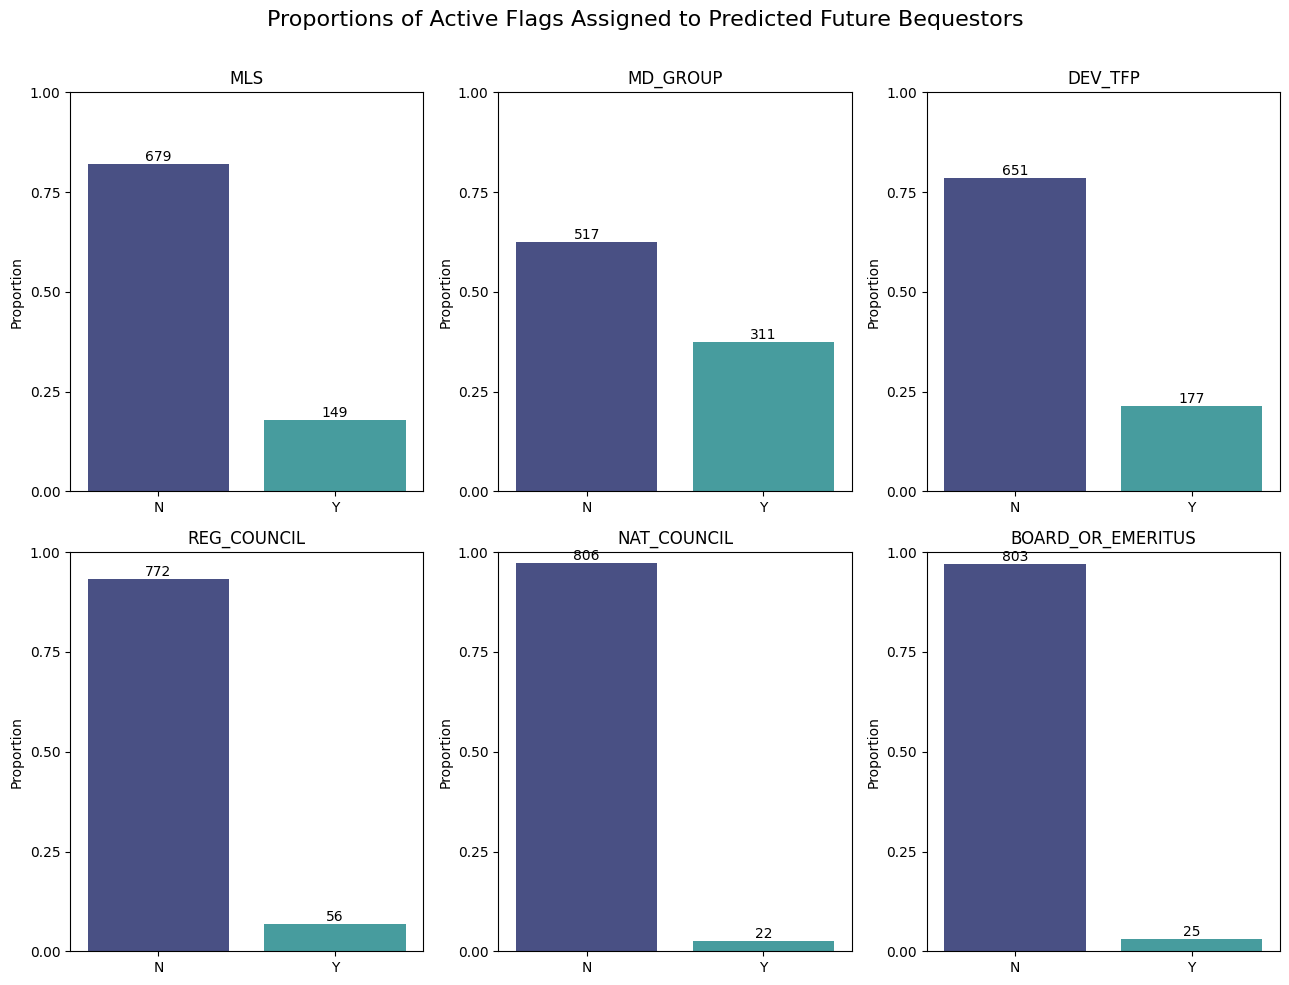

In [18]:

# Create a figure with a 3x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(13, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Set a color palette
colors = sns.color_palette("mako", 2)  # Choose a palette with two colors

# Find the common axis limits
max_y = 1  # We know the max will be 1 since we're normalizing

# Loop through each column and plot the proportions
for i, col in enumerate(vis_columns):
    value_counts = pred_flags[col].value_counts()
    proportions = value_counts / len(pred_flags)
    proportions = proportions.reset_index()
    proportions.columns = ['Value', 'Proportion']
    proportions = proportions.sort_values(by='Value')  # Sort to ensure alphabetical order
    sns.barplot(x='Value', y='Proportion', data=proportions, ax=axes[i], palette=colors, hue = 'Value')
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel('Proportion')
    axes[i].set_xlabel('')
    axes[i].set_ylim(0, max_y)

    # Ensure y-axis ticks include 0 and 1
    axes[i].set_yticks([0, 0.25, 0.5, 0.75, 1])
    
    # Add counts above the bars
    for index, row in proportions.iterrows():
        count = value_counts[row['Value']]
        axes[i].text(index, row['Proportion'], int(count), color='black', ha="center", va="bottom")

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a suptitle for the entire figure
fig.suptitle('Proportions of Active Flags Assigned to Predicted Future Bequestors', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust rect to make room for the suptitle
plt.show()

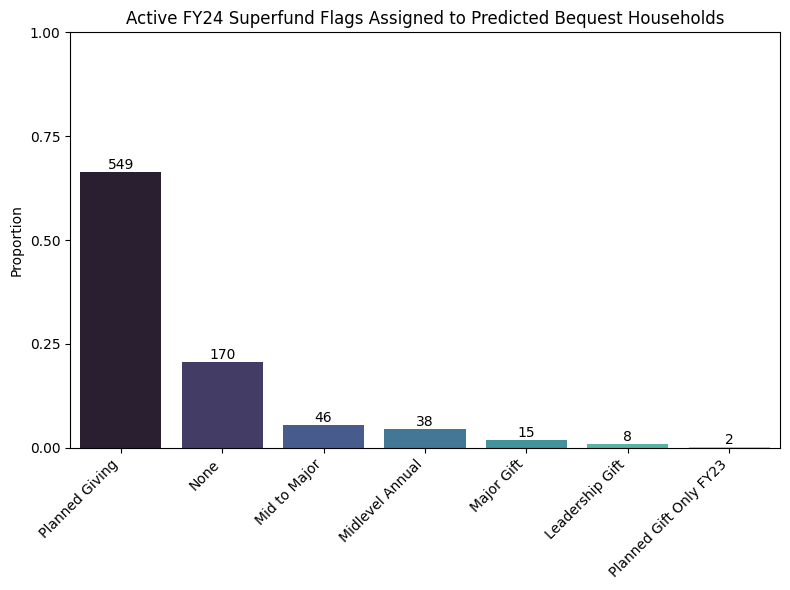

In [19]:

# Define the specific column to visualize
superfund = 'SUPERFUND'

# Set a color palette
colors = sns.color_palette("mako", 7)  

# Calculate proportions for the specific column
value_counts = pred_flags[superfund].value_counts()
proportions = value_counts / len(pred_flags)
proportions = proportions.reset_index()
proportions.columns = ['Value', 'Proportion']

# Create a figure for the specific plot
plt.figure(figsize=(8, 6))

# Plot the proportions
plot = sns.barplot(x='Value', y='Proportion', data=proportions, hue='Value', palette=colors)

# Set title and labels
plt.title('Active FY24 Superfund Flags Assigned to Predicted Bequest Households')
plt.ylabel('Proportion')
plt.xlabel('')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add counts above the bars
for index, row in proportions.iterrows():
    plot.text(index, row.Proportion, value_counts[row.Value], color='black', ha="center", va="bottom")

# Ensure y-axis ticks include 0 and 1
plt.ylim(0, 1)
plt.yticks([0, 0.25, 0.5, 0.75, 1])

# Show plot
plt.tight_layout()
plt.show()

In [23]:
planned_gift_only = pred_flags[pred_flags['SUPERFUND'] == 'Planned Gift Only FY23']
planned_gift_only

,ROI_FAMILY_ID,ROI_ID,CITY,STATE,ZIPCODE,SOLICIT_NO_MAIL,NO_EMAIL,MD_GROUP,DEV_TFP,MLS,REG_COUNCIL,NAT_COUNCIL,VET_COUNCIL,CF_GROUP,BOARD_OR_EMERITUS,SUPERFUND,SUPERFUND_PLANNEDGIFT,NP_ROLE_STAFF
245,26983619,26983619,Philadelphia,PA,19129,N,N,N,N,N,N,N,N,N,N,Planned Gift Only FY23,None,N
690,100017823,100017823,Rincon,GA,31326-4900,N,N,N,N,N,N,N,N,N,N,Planned Gift Only FY23,None,N


In [20]:
# Load full dataset used for training and testing - get DOBs
bequests_clean = pd.read_csv('bequests_clean.csv')

In [21]:
bequests_clean.columns

Index(['ROI_ID', 'ROI_FAMILY_ID', 'STATE', 'REGION_CODE', 'TOTAL_TRANSACTIONS',
       'TOTAL_AMOUNT', 'FIRST_GIFT_AMOUNT', 'MRC_AMOUNT', 'HPC_AMOUNT',
       'DEATH_FLAG', 'YEARS_SINCE_FIRST_GIFT', 'YEARS_SINCE_MRC_GIFT',
       'YEARS_SINCE_HPC_GIFT', 'BEQUEST_RECEIVED', 'BIRTH_YEAR', 'LE'],
      dtype='object')

In [28]:
# Add BIRTH_YEAR to pred_ids_df from bequests_clean using ROI_FAMILY_ID
pred_ids_df = pd.merge(pred_ids_df, bequests_clean[['ROI_FAMILY_ID', 'BIRTH_YEAR']], on='ROI_FAMILY_ID', how='left')

In [29]:
# create age column from BIRTH_YEAR in pred_flags
pred_ids_df['AGE'] = 2024 - pred_ids_df['BIRTH_YEAR']
pred_ids_df.head()

,ROI_FAMILY_ID,BIRTH_YEAR,AGE
0,79476974,1931.0,93.0
1,79540779,1940.0,84.0
2,79733218,NaN,NaN
3,79836425,1973.0,51.0
4,79987970,NaN,NaN


In [30]:
# count total number of pred_flag unique ROI_FAMILY_ID with AGE > or equal to 85
age_85 = pred_ids_df[pred_ids_df['AGE'] >= 85]
age_85['ROI_FAMILY_ID'].nunique()

208

In [31]:
pred_ids_df.shape

(1377, 3)

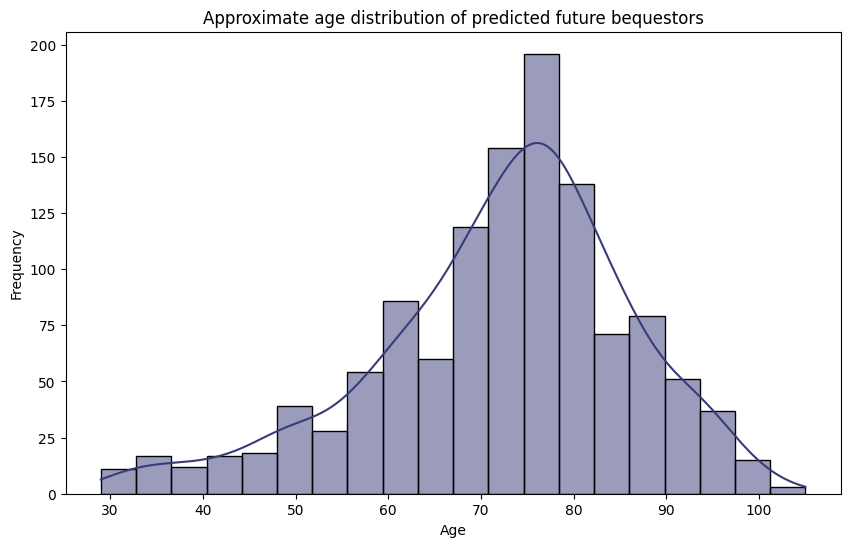

In [32]:
# Define colors
hist_color = '#393b79'  

# Plot age distribution of predicted future bequestors
plt.figure(figsize=(10, 6))
sns.histplot(pred_ids_df['AGE'], bins=20, kde=True, 
             color=hist_color)
plt.title('Approximate age distribution of predicted future bequestors')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()
